In [3]:
import sys
import pandas as pd
import datetime as dt
from queue import Queue

sys.path.append("../") # adding path to library

from library.backtester import backtest
from library.backtester.portfolio import NaivePortfolio
from library.backtester.strategy import BuyAndHoldStrategy
from library.backtester.data import FtxHistoricCSVDataHandler
from library.backtester.execution import SimulatedExecutionHandler

### Создаем очередь событий

Event-driven backtest основывается на принципе появления событий. Каждое событие несет в себе какое-то событие, будь то появление маркет даты, или исполнения ордеров. В нашем примере мы создаем очередь событий и предоставляем к ней доступ для всех модулей, чтобы каждый элемент имел к ней доступ

In [50]:
events = Queue()

### Показываем бэктестеру, где лежат наши данные

Вообще, архитектура позволяет дописывать обработчики данных для разных форматов, но в примере мы рассмотрим обработчик csv данных, предполагающий наличие csv файлов в формате, в котором ftx выдает исторические данные. Предполагается, что для каждого актива имеем по csv файлу с названием *ticker*.csv, пример ниже:

In [51]:
!ls ../data

ABNBUSD.csv BTCUSDT.csv ETHUSDT.csv


О том, как получить данные в таком формате можно почитать в предыдущем ноутбуке

Объявляем обработчик данных, предоставляя ему доступ к очереди событий, указывая на директорию с цсвшками и передавая список тикеров, которые мы будем гонять в бэктестере. Кстати, мы назвали переменную bars, потому что исторические данные -- это свечи, а не просто цена закрытия.

In [52]:
!head -n 3 ../data/ABNBUSD.csv

startTime,time,open,high,low,close,volume
2020-12-09T04:30:00+00:00,1607488200000.0,60.0775,60.0775,59.865,59.865,0.0
2020-12-09T04:35:00+00:00,1607488500000.0,59.865,59.99,59.865,59.99,0.0


In [53]:
bars = FtxHistoricCSVDataHandler(events=events, csv_dir='../data', symbol_list=['BTCUSDT'])

### Определяем используемую стратегию

В трейдинге широко распространенной практикой является тестирование стратегий в сравнении с каким-либо бенчмарком. Обычно бэнчмарк выбирается исходя из каких-то специфичных размышлений, я выбрал в качестве первого приближения считать бэнчмарком портфель buy and hold. Стратегия наследуется от шаблона стратегий, описанного в `library.backtester.strategy`, поэтому можно легко дописывать свои стратегии.

In [54]:
strategy = BuyAndHoldStrategy(bars=bars, events=events)

### Определяем портфель

Портфель выполняет функции по анализу проведенных торгов, сбору метрик и аггрегации результатов. Кроме того, портфель отдает приказы брокеру, руководствуясь сигналами стратегии и наличию доступных средств. Нынешняя реализация портфеля наивна в смысле отсуствия риск-менеджмента, а также фиксированному количеству покупаемых активов.

In [55]:
portfolio = NaivePortfolio(bars=bars, events=events, start_date=dt.datetime(2020, 8, 1), initial_capital=6_500)

### Добавляем исполнителя сделок

In [56]:
broker = SimulatedExecutionHandler(events)

### Запускам бэктестер

In [ ]:
backtest(events, bars, strategy, portfolio, broker)
results = portfolio.create_equity_curve_dataframe()

Важно, что функция backtest меняет внутренние переменные всех модулей, что наверное не очень хорошо, и это нужно будет как-то переосмыслить, но вот какие результаты мы получаем.

In [79]:
results

,BTCUSDT,cash,commission,total,returns,equity_curve
datetime,,,,,,
2020-08-01 00:00:00,0.00,6500.0000,0.0000,6500.0000,NaN,NaN
2020-03-28 14:40:00,0.00,6500.0000,0.0000,6500.0000,0.000000,1.000000
2020-03-28 14:45:00,6229.25,275.7493,0.0007,6504.9993,0.000769,1.000769
2020-03-28 14:50:00,6235.50,275.7493,0.0007,6511.2493,0.000961,1.001731
2020-03-28 14:55:00,6239.00,275.7493,0.0007,6514.7493,0.000538,1.002269
...,...,...,...,...,...,...
2021-02-05 20:45:00,37716.00,275.7493,0.0007,37991.7493,-0.000421,5.844885
2021-02-05 20:50:00,37729.00,275.7493,0.0007,38004.7493,0.000342,5.846885
2021-02-05 20:55:00,37748.00,275.7493,0.0007,38023.7493,0.000500,5.849808


И действительно, вложившись в биткойн в конце 2020 года мы бы имели в 6 раз больше вложенных денег. 

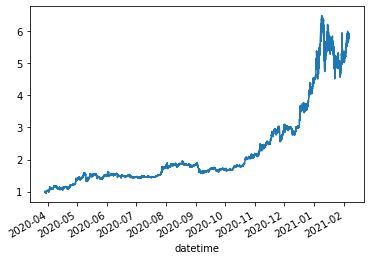

In [81]:
results['equity_curve'].plot();